# Wind storm workflow (now only raster based, single event)

TODO: update towards vector and multi event sets

load packages


In [3]:
import os
import pooch

import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

from damagescanner.core import RasterScanner
from damagescanner.plot import damagemap_raster

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy


# added later
import cdsapi
from zipfile import ZipFile
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
import numpy as np
import matplotlib
import damagescanner




## Load in data

In [6]:
dir =  ""#
workflow_folder = os.path.join(dir, '')
data_dir = os.path.join(workflow_folder,'data')


### Load in windmaps

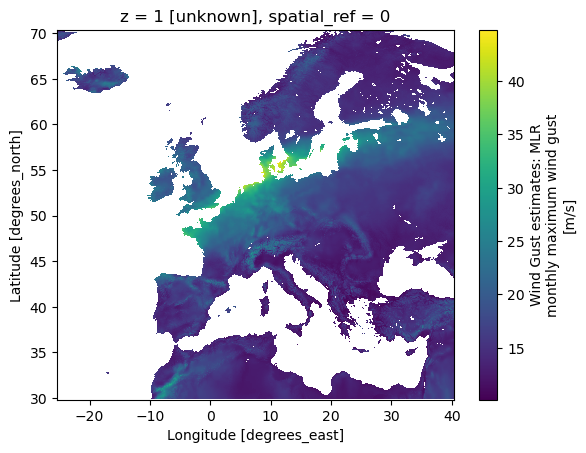

In [7]:
with ZipFile(f"{data_dir}/Carmen.zip") as zf:
    
    # Let's get the filename first
    file = zf.namelist()[0]
    
    # And now we can open and select the file within Python
    with zf.open(file) as f:
        windstorm_europe = xr.open_dataset(f)

windstorm_europe = windstorm_europe.rename({'Latitude': 'y','Longitude': 'x'})
windstorm_europe = windstorm_europe.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

windstorm_europe.rio.write_crs(4326, inplace=True)
# set x and y instead of lon and lat

windstorm_europe['FX'].plot()

### set to region specific

create bounding box. See https://boundingbox.klokantech.com/ to get the bounding box of your area of interest (select csv in the copy-paste field at the bottom of the website window)


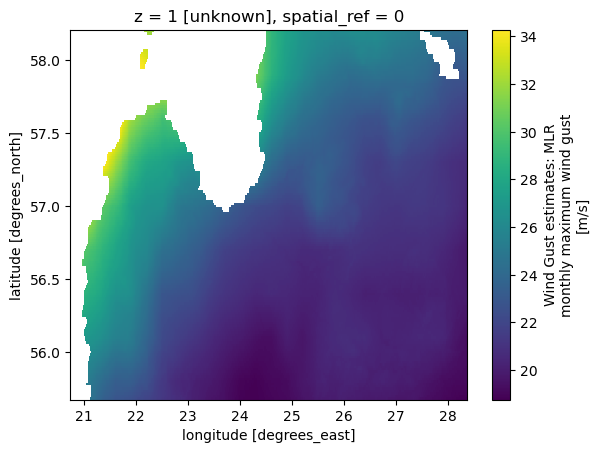

In [8]:
bbox = [20.7419,55.6919,28.35,58.1956] # [lon_min, lat_min, lon_max, lat_max]

windstorm_region = windstorm_europe.rio.clip_box(*bbox, 
                                                 crs=4326)


windstorm_region['FX'].plot()


## Load in land use data and set to region

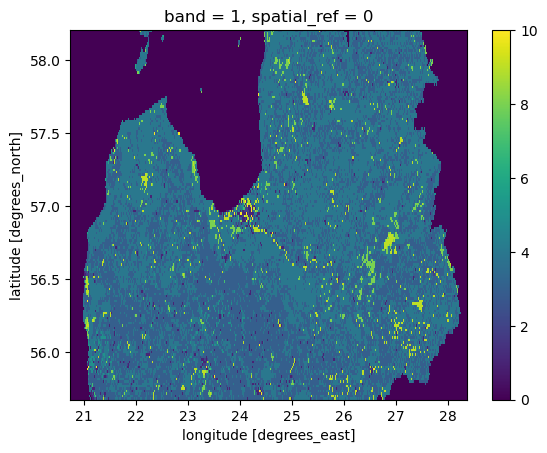

In [9]:
filename_land_use = f'{data_dir}/LUISA_LU/2030_LUISA_LU.tif'
# filename_land_use =  f'{data_dir}/U2018_CLC2018_V2020_20u1.tif'
land_use = rxr.open_rasterio(filename_land_use)

# clip land use to the same extent as the windstorm
land_use_region = land_use.rio.clip_box(*bbox,
                                        crs=4326)

# match projection and resolution of the windstorm
land_use_region = land_use_region.rio.reproject_match(windstorm_region)

# plot the land use
land_use_region.plot()


### match both data sets and prepare for DamageScanner

In [10]:
# set both land use and windstorm to similar resolution. Keep the most detailed resolution
if land_use_region.rio.resolution()[0] > windstorm_region.rio.resolution()[0]:
    land_use_region = land_use_region.interp_like(windstorm_region, method='nearest')
    print("windstorm resolution is higher than land use resolution. Land use resolution is changed to match windstorm resolution")
else:
    windstorm_region = windstorm_region.interp_like(land_use_region, method='nearest')
    print("land use resolution is higher than windstorm resolution. Windstorm resolution is changed to match land use resolution")

land use resolution is higher than windstorm resolution. Windstorm resolution is changed to match land use resolution


check if both match

Text(0.5, 1.0, 'Windstorm Carmen 2018 and land use 2030')

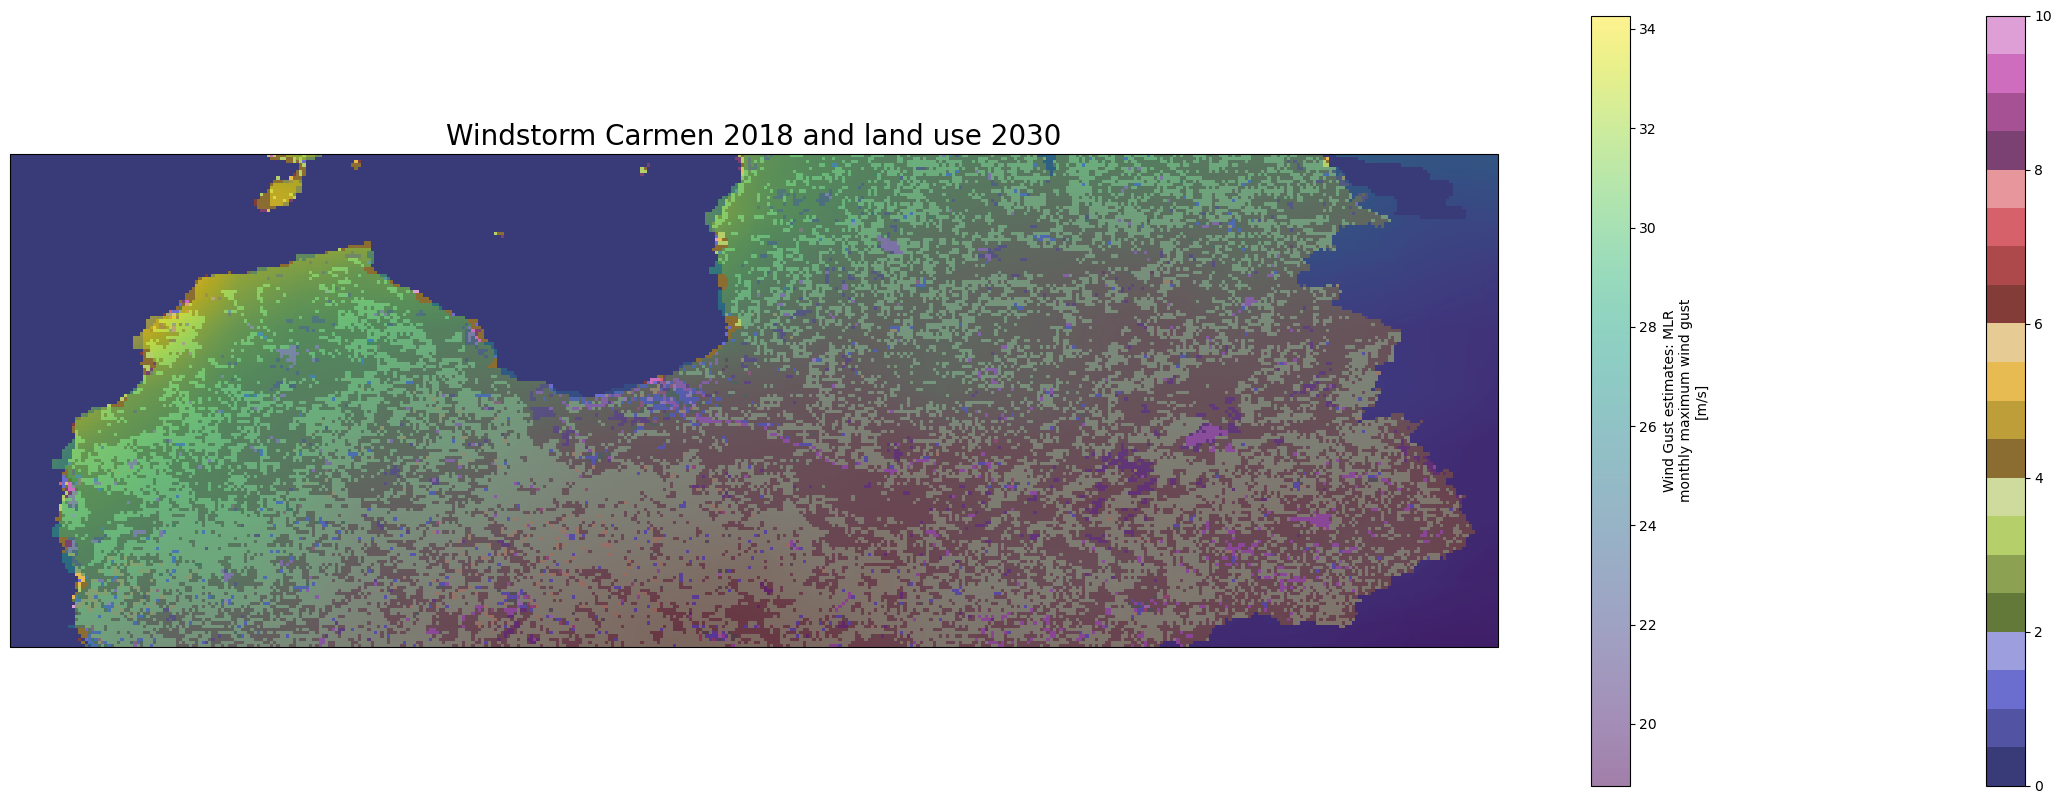

In [11]:
# plot
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
land_use_region.plot(ax=ax, cmap='tab20b', alpha=1)
windstorm_region['FX'].plot(ax=ax, cmap='viridis', alpha=0.5)
ax.set_title('Windstorm Carmen 2018 and land use 2030', fontsize=20)

In [12]:
# convert to Latitude and Longitude from x and y and 
windstorm_region = windstorm_region.rename({'x': 'Latitude', 'y': 'Longitude'})
land_use_region = land_use_region.rename({'x': 'Latitude', 'y': 'Longitude'})

# reproject to 3857 for the damage scanner
windstorm_region = windstorm_region.rio.reproject(3857)
windstorm_region = windstorm_region['FX'][0]

land_use_region = land_use_region.rio.reproject(3857)
land_use_region = land_use_region[0]

# check resolution of the windstorm
print(f"the resolution of the windstorm is {windstorm_region.rio.resolution()[0]} meters by {windstorm_region.rio.resolution()[0]} meters")

# check resolution of the land use
print(f"the resolution of the land use is {land_use_region.rio.resolution()[0]} meters by {land_use_region.rio.resolution()[0]} meters")



the resolution of the windstorm is 2061.370249184533 meters by 2061.370249184533 meters
the resolution of the land use is 2061.370249184533 meters by 2061.370249184533 meters


### testing purpose!!

In [13]:
np.unique(land_use_region)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8)

In [14]:
# set all values to a random number from 
numbers = [110,111,112,120,130,131,132,133,134,135,136,140,141,142,143,144,150,151,152,210,211,220,221,230,240,250,310,320,330,340,350,360,370,380,410,420,430,440,450,460,470,510,520,530,540,550,560,610,620,630,640,650]

# set new values
land_use_region = land_use_region.where(land_use_region < 2, np.random.choice(numbers, size=land_use_region.shape, replace=True))

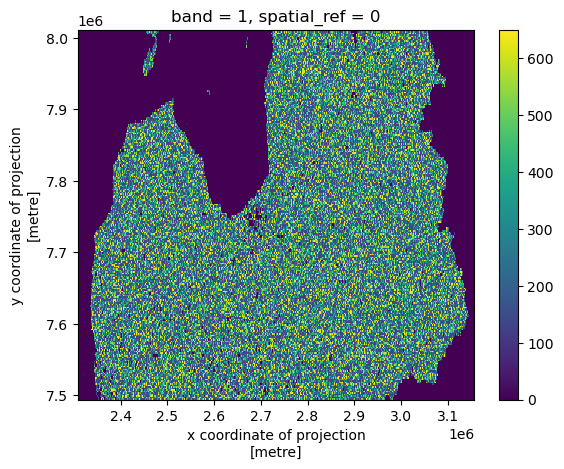

In [15]:
land_use_region.plot()

## save maps to serve as inputs for DamageScanner

In [16]:
# save both maps as nc
# land_use_region.to_netcdf(f'{data_dir}/LUISA_LU/2030_LUISA_LU_region.nc')
# windstorm_region.to_netcdf(f'{data_dir}/Carmen_region.nc')

# save to tiff

# land_use_region.rio.to_raster(f'{data_dir}/LUISA_LU/2030_LUISA_LU_region.tiff')
# windstorm_region.rio.to_raster(f'{data_dir}/Carmen_region.tiff')


In [17]:
windstorm_region.shape

(251, 412)

In [18]:
land_use_region.shape

(251, 412)

## Run damage scanner

In [19]:
curve_path = os.path.join(data_dir,'curves.csv')
maxdam_path = os.path.join(data_dir,'maxdam.csv')

wind_damage_land_use = RasterScanner(   land_use_region,
                                        windstorm_region,
                                        curve_path,
                                        maxdam_path,
                                        scenario_name='Carmen',
                                        lu_crs=land_use_region.rio.crs, # 4326
                                        haz_crs=windstorm_region.rio.crs, # 4326                   
                                        dtype = np.int64, # if set to int32 it gives an error
                                        save=False)

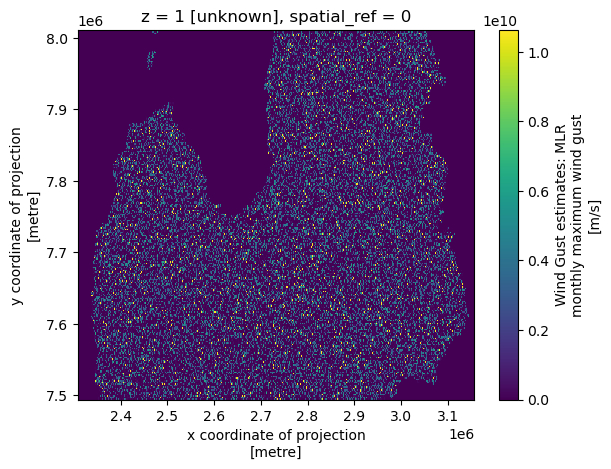

In [20]:
wind_damage_land_use[1].plot()

## Check results

In [18]:
# read in tiff 